<a href="https://colab.research.google.com/github/Sushrut0202/CIIMS/blob/main/Combined_Antibiotic_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving AMR data for class wise resistance viz.xlsx to AMR data for class wise resistance viz.xlsx
Resistance counts per antibiotic (top 20):
Benzylpenicillin                   19
Amoxycillin/Clavulanic acid        18
Cefuroxime                         17
Cefuroxime Axetil                  16
Erythromycin                       10
Ciprofloxacin                      10
Clindamycin                         8
Ceftriaxone                         6
Levofloxacin                        4
Tetracyclin                         2
Gentamicin High Level (synergy)     2
Gentamycin                          2
Trimethoprim/Sulfamethoxazole       2
Piperacillin/Tazobactum             0
Gentamicin                          0
Cefoperazone/Sulbactum              0
Imipenum                            0
Metropenem                          0
Cefepime                            0
Entrapenum                          0
dtype: int64

Antibiotic -> class mapping (unique classes):
Other               11
Cephalosporins  

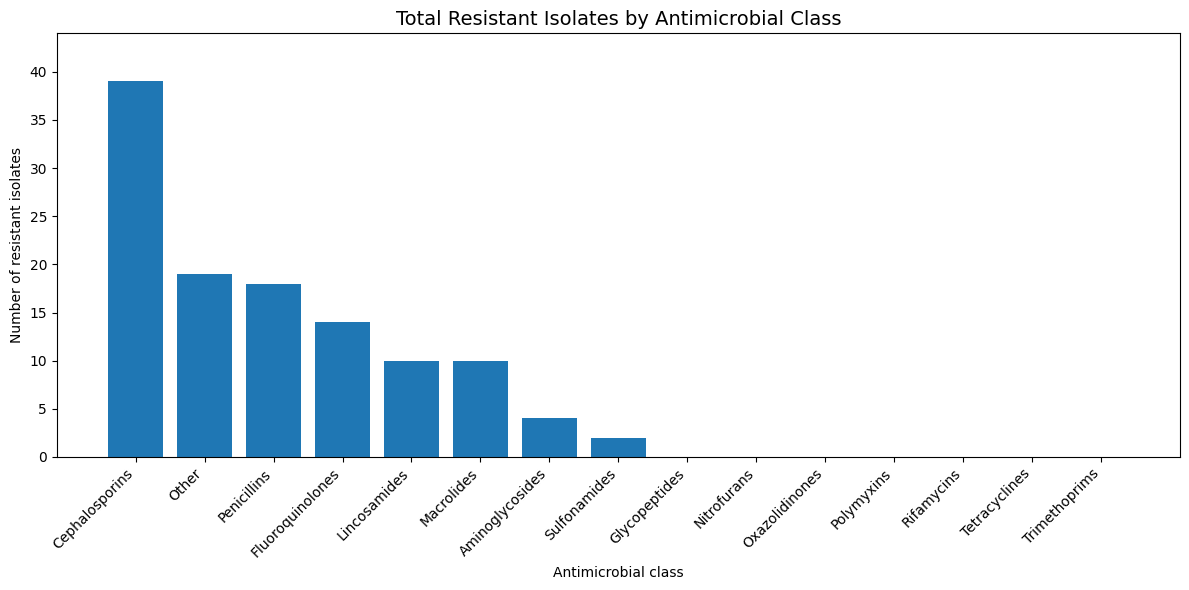

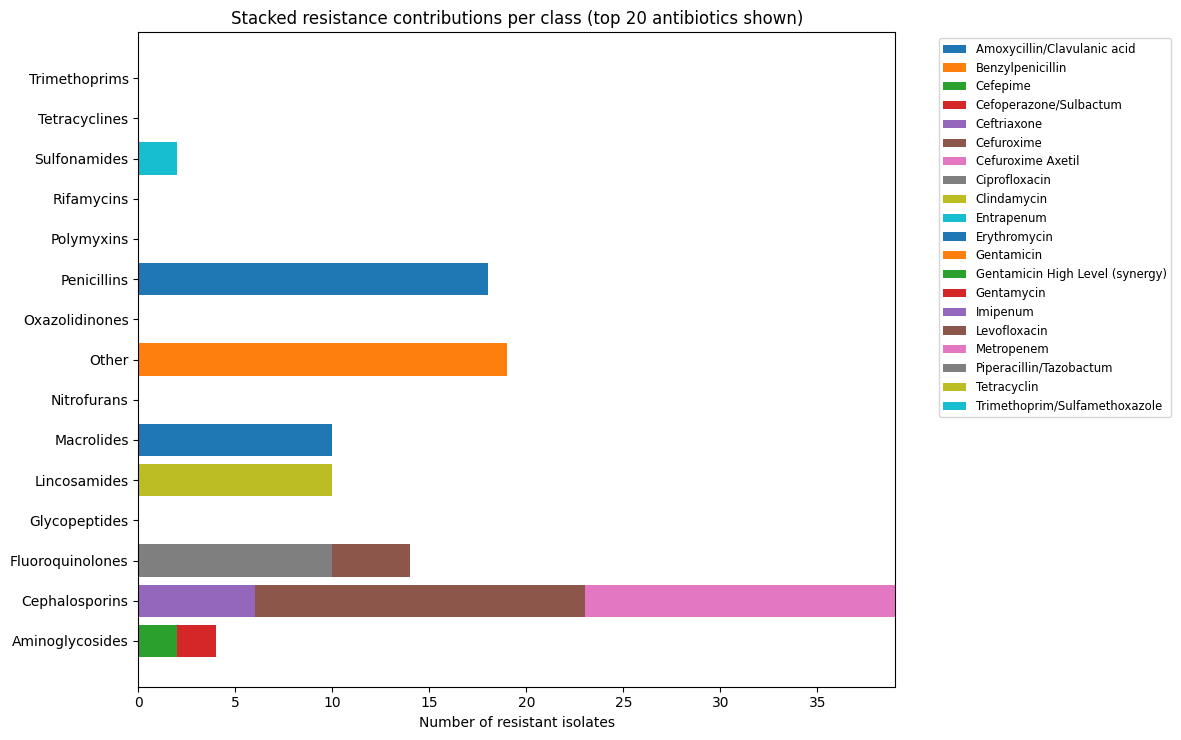

In [1]:
# === 1. Upload Excel file ===
from google.colab import files
uploaded = files.upload()

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# === 2. Read the uploaded file ===
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# === 3. Fix antibiotic headers (names are in row 0, cols 15–50) ===
start_idx = 15          # first antibiotic column index
end_idx   = 50          # last antibiotic column index (before 'Selected for ANDC')

abx_name_row = df.iloc[0, start_idx:end_idx+1]

new_cols = list(df.columns)
new_cols[start_idx:end_idx+1] = abx_name_row.tolist()
df.columns = new_cols

# Drop the row that contained antibiotic names
df = df.drop(index=0).reset_index(drop=True)

# === 4. Extract antibiotic columns ===
abx = df.iloc[:, start_idx:end_idx+1]

# === 5. Clean values (strip spaces, uppercase) ===
abx_clean = abx.astype(str).apply(lambda x: x.str.strip().str.upper())

# IMPORTANT: make sure we are NOT shortening names anywhere:
# (remove any lines like: abx_clean.columns = abx_clean.columns.str[:3])

# === 6. Count resistant isolates ("R") per antibiotic ===
resistance_counts = (abx_clean == "R").sum()
resistance_counts = resistance_counts.sort_values(ascending=False)

print("Resistance counts per antibiotic (top 20):")
print(resistance_counts.head(20))

# === 7. Map antibiotics to classes (keyword-based, extendable) ===
# NOTE: extend or adapt this mapping to match your exact column naming conventions
ABX_KEYWORD_TO_CLASS = {
    # aminoglycosides
    "AMIKACIN": "Aminoglycosides", "AMK": "Aminoglycosides", "GENTAMICIN": "Aminoglycosides", "GEN": "Aminoglycosides",
    "TOBRAMYCIN": "Aminoglycosides", "TOB": "Aminoglycosides", "KANAMYCIN": "Aminoglycosides", "KAN": "Aminoglycosides",
    # carbapenems
    "IMIPENEM": "Carbapenems", "IPM": "Carbapenems", "MEROPENEM": "Carbapenems", "MEM": "Carbapenems", "ERTAPENEM": "Carbapenems",
    # cephalosporins (general + generations)
    "CEFTRIAXONE": "Cephalosporins", "CEFOTAXIME": "Cephalosporins", "CEFTAZIDIME": "Cephalosporins", "CEFEPIME": "Cephalosporins",
    "CEFUROXIME": "Cephalosporins", "CEFAZOLIN": "Cephalosporins",
    # fluoroquinolones / quinolones
    "CIPROFLOXACIN": "Fluoroquinolones", "CIPRO": "Fluoroquinolones", "LEVOFLOXACIN": "Fluoroquinolones", "OFLOXACIN": "Fluoroquinolones",
    # macrolides
    "AZITHROMYCIN": "Macrolides", "ERYTHROMYCIN": "Macrolides", "CLARITHROMYCIN": "Macrolides",
    # penicillins / beta-lactams
    "PIPERACILLIN": "Penicillins", "AMPICILLIN": "Penicillins", "AMOXICILLIN": "Penicillins",
    "AMOX": "Penicillins", "PIPERACILLIN/TAZOBACTAM": "Penicillins (with inhibitor)", "TZP": "Penicillins (with inhibitor)",
    # glycopeptides
    "VANCOMYCIN": "Glycopeptides", "VAN": "Glycopeptides", "TEICOPLANIN": "Glycopeptides",
    # polymyxins
    "COLISTIN": "Polymyxins", "COL": "Polymyxins",
    # tetracyclines
    "TETRACYCLINE": "Tetracyclines", "DOXYCYCLINE": "Tetracyclines", "TIGECYCLINE": "Tetracyclines",
    # lincosamides
    "CLINDAMYCIN": "Lincosamides", "CLI": "Lincosamides",
    # oxazolidinones
    "LINEZOLID": "Oxazolidinones",
    # nitrofurans
    "NITROFURANTOIN": "Nitrofurans", "NITROFURAN": "Nitrofurans",
    # rifamycins
    "RIFAMPICIN": "Rifamycins", "RIFAMPIN": "Rifamycins",
    # phenicols
    "CHLORAMPHENICOL": "Phenicols",
    # sulfonamides / trimethoprim
    "SULFAMETHOXAZOLE": "Sulfonamides", "TRIMETHOPRIM": "Trimethoprims", "CO-TRIMOXAZOLE": "Sulfonamides/Trimethoprim",
    "SXT": "Sulfonamides/Trimethoprim", "TMP-SMX": "Sulfonamides/Trimethoprim",
    # monobactams
    "AZTREONAM": "Monobactams",
    # others (add more as needed)
}

def assign_class_by_keywords(ab_name):
    """Return a class name by searching keywords in antibiotic name."""
    if pd.isna(ab_name):
        return "Unknown"
    name = str(ab_name).upper()
    # first try exact mapping keys (use uppercase keys)
    for key, cls in ABX_KEYWORD_TO_CLASS.items():
        if key in name:
            return cls
    # fallback heuristics: check common abbreviations separated by spaces or slashes
    tokens = [t for t in re.split(r"[ \-/()]+", name) if t]
    for t in tokens:
        for key, cls in ABX_KEYWORD_TO_CLASS.items():
            if key == t:
                return cls
    return "Other"

import re
# Create series mapping antibiotic (full name) -> class
abx_to_class = pd.Series(index=resistance_counts.index, dtype="object")
for col in resistance_counts.index:
    abx_to_class.loc[col] = assign_class_by_keywords(col)

# Show mapping summary
print("\nAntibiotic -> class mapping (unique classes):")
print(abx_to_class.value_counts())

# === 8. Aggregate resistance counts by class ===
class_grouped = resistance_counts.groupby(abx_to_class).sum()
class_grouped = class_grouped.sort_values(ascending=False)

print("\nResistance counts by class:")
print(class_grouped)

# === 9. Plot: (A) Aggregated counts by class ===
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(class_grouped))
ax.bar(x, class_grouped.values)
ax.set_xticks(x)
ax.set_xticklabels(class_grouped.index, rotation=45, ha="right")
ax.set_title("Total Resistant Isolates by Antimicrobial Class", fontsize=14)
ax.set_xlabel("Antimicrobial class")
ax.set_ylabel("Number of resistant isolates")
ax.set_ylim(0, class_grouped.max() + max(5, int(0.05 * class_grouped.max())))
plt.tight_layout()
plt.show()

# === 10. Optional: Stacked bar showing antibiotics per class (top contributors) ===
# Build a pivot table: classes x antibiotics (counts), but drop antibiotics with zero or very low counts if desired
counts_df = resistance_counts.to_frame(name="resistant_count").reset_index().rename(columns={"index":"antibiotic"})
counts_df["class"] = counts_df["antibiotic"].map(abx_to_class)

pivot = counts_df.pivot(index="class", columns="antibiotic", values="resistant_count").fillna(0)

# Optionally reduce to top-n antibiotics overall to keep plot readable
TOP_N_ABX = 20
top_abx = resistance_counts.head(TOP_N_ABX).index.tolist()
pivot_reduced = pivot.loc[:, pivot.columns.isin(top_abx)]

# Plot stacked horizontal bars (classes on y)
fig, ax = plt.subplots(figsize=(12, max(6, 0.5 * len(pivot_reduced.index))))
bottom = np.zeros(len(pivot_reduced))
antibiotics_order = list(pivot_reduced.columns)
for ab in antibiotics_order:
    vals = pivot_reduced[ab].values
    ax.barh(pivot_reduced.index, vals, left=bottom, label=ab)
    bottom = bottom + vals

ax.set_xlabel("Number of resistant isolates")
ax.set_title(f"Stacked resistance contributions per class (top {TOP_N_ABX} antibiotics shown)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


Saving AMR data for class wise resistance viz.xlsx to AMR data for class wise resistance viz (2).xlsx
Resistance counts per antibiotic (top 20):
Benzylpenicillin                   19
Amoxycillin/Clavulanic acid        18
Cefuroxime                         17
Cefuroxime Axetil                  16
Erythromycin                       10
Ciprofloxacin                      10
Clindamycin                         8
Ceftriaxone                         6
Levofloxacin                        4
Tetracyclin                         2
Gentamicin High Level (synergy)     2
Gentamycin                          2
Trimethoprim/Sulfamethoxazole       2
Piperacillin/Tazobactum             0
Gentamicin                          0
Cefoperazone/Sulbactum              0
Imipenum                            0
Metropenem                          0
Cefepime                            0
Entrapenum                          0
dtype: int64

Antibiotic -> class mapping (unique classes):
Other               11
Cephalospori

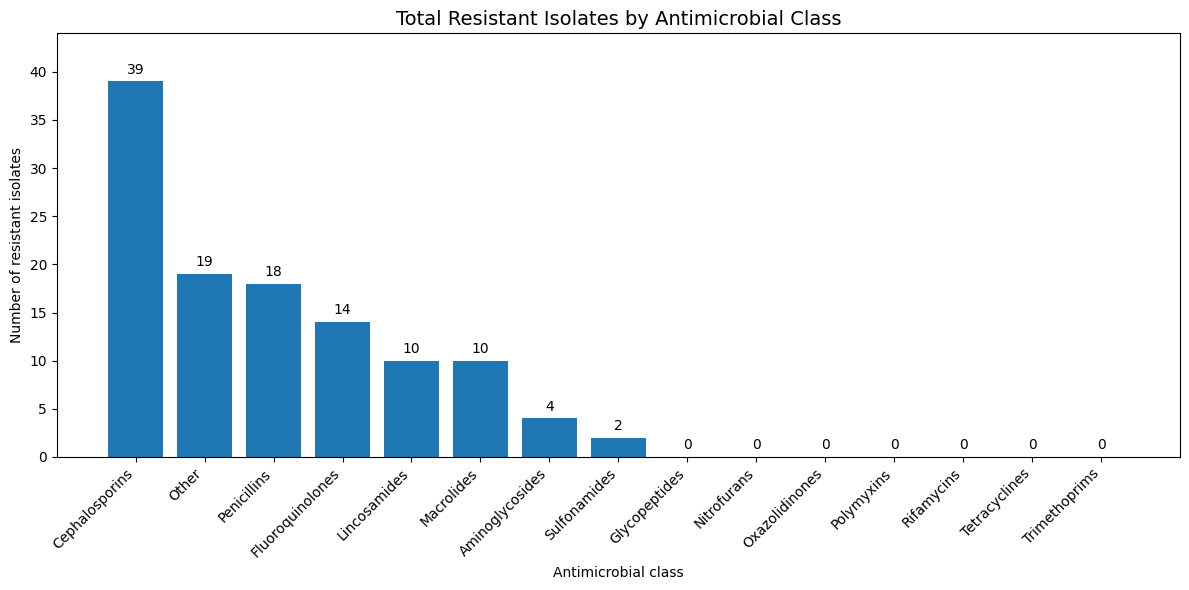

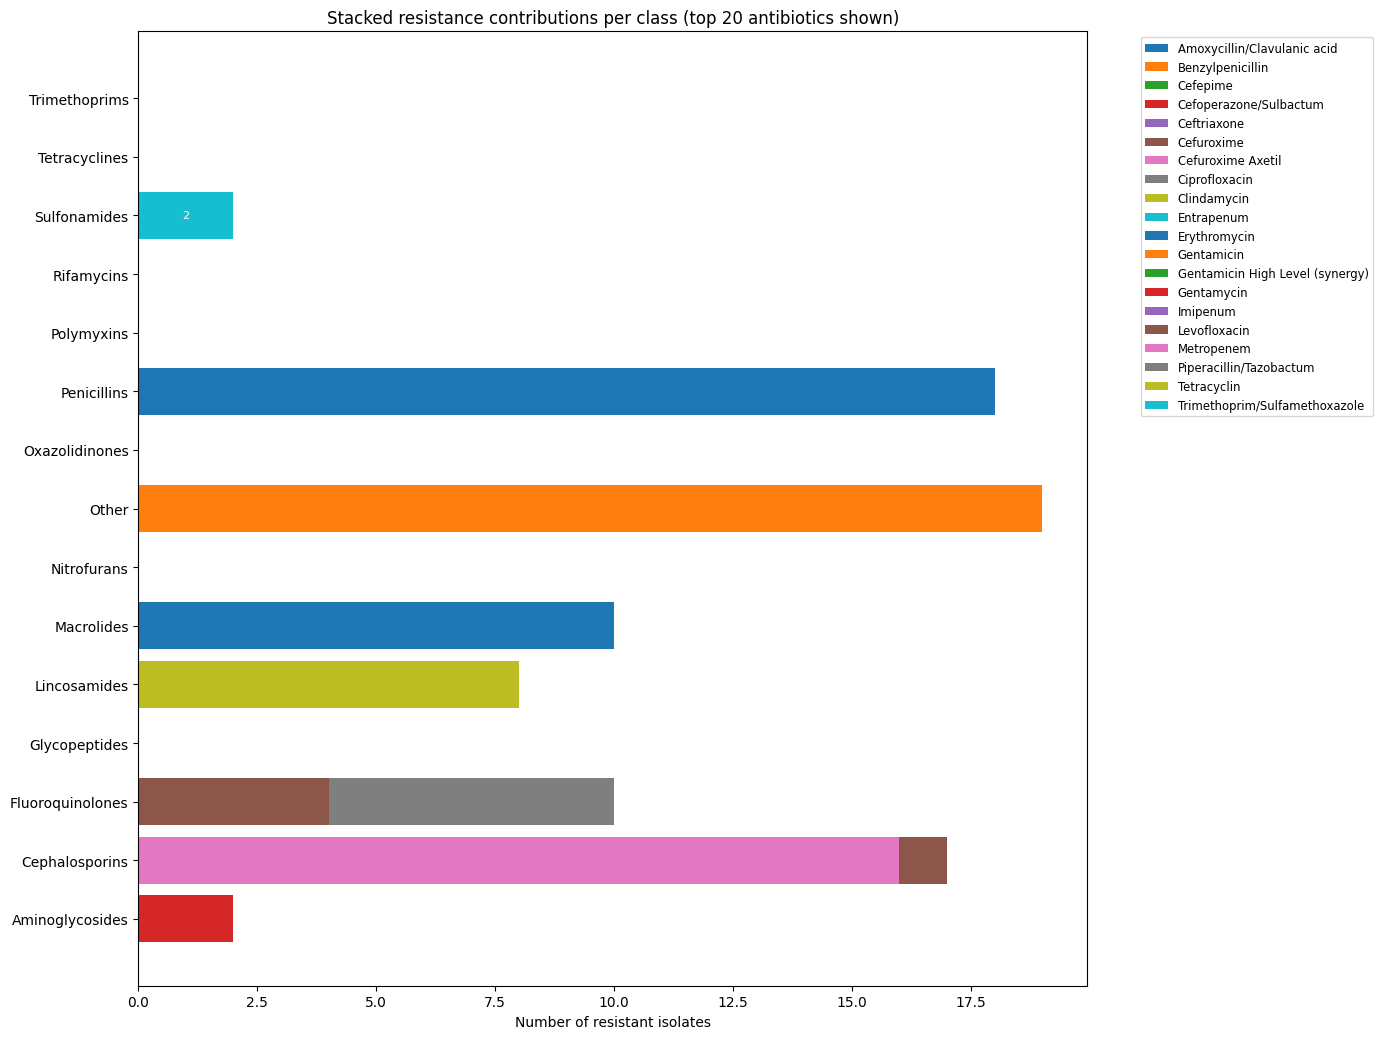

In [3]:
# === 1. Upload Excel file ===
from google.colab import files
uploaded = files.upload()

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# === 2. Read the uploaded file ===
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# === 3. Fix antibiotic headers (names are in row 0, cols 15–50) ===
start_idx = 15          # first antibiotic column index
end_idx   = 50          # last antibiotic column index (before 'Selected for ANDC')

abx_name_row = df.iloc[0, start_idx:end_idx+1]

new_cols = list(df.columns)
new_cols[start_idx:end_idx+1] = abx_name_row.tolist()
df.columns = new_cols

# Drop the row that contained antibiotic names
df = df.drop(index=0).reset_index(drop=True)

# === 4. Extract antibiotic columns ===
abx = df.iloc[:, start_idx:end_idx+1]

# === 5. Clean values (strip spaces, uppercase) ===
abx_clean = abx.astype(str).apply(lambda x: x.str.strip().str.upper())

# IMPORTANT: make sure we are NOT shortening names anywhere:
# (remove any lines like: abx_clean.columns = abx_clean.columns.str[:3])

# === 6. Count resistant isolates ("R") per antibiotic ===
resistance_counts = (abx_clean == "R").sum()
resistance_counts = resistance_counts.sort_values(ascending=False)

print("Resistance counts per antibiotic (top 20):")
print(resistance_counts.head(20))

# === 7. Map antibiotics to classes (keyword-based, extendable) ===
# NOTE: extend or adapt this mapping to match your exact column naming conventions
ABX_KEYWORD_TO_CLASS = {
    # aminoglycosides
    "AMIKACIN": "Aminoglycosides", "AMK": "Aminoglycosides", "GENTAMICIN": "Aminoglycosides", "GEN": "Aminoglycosides",
    "TOBRAMYCIN": "Aminoglycosides", "TOB": "Aminoglycosides", "KANAMYCIN": "Aminoglycosides", "KAN": "Aminoglycosides",
    # carbapenems
    "IMIPENEM": "Carbapenems", "IPM": "Carbapenems", "MEROPENEM": "Carbapenems", "MEM": "Carbapenems", "ERTAPENEM": "Carbapenems",
    # cephalosporins (general + generations)
    "CEFTRIAXONE": "Cephalosporins", "CEFOTAXIME": "Cephalosporins", "CEFTAZIDIME": "Cephalosporins", "CEFEPIME": "Cephalosporins",
    "CEFUROXIME": "Cephalosporins", "CEFAZOLIN": "Cephalosporins",
    # fluoroquinolones / quinolones
    "CIPROFLOXACIN": "Fluoroquinolones", "CIPRO": "Fluoroquinolones", "LEVOFLOXACIN": "Fluoroquinolones", "OFLOXACIN": "Fluoroquinolones",
    # macrolides
    "AZITHROMYCIN": "Macrolides", "ERYTHROMYCIN": "Macrolides", "CLARITHROMYCIN": "Macrolides",
    # penicillins / beta-lactams
    "PIPERACILLIN": "Penicillins", "AMPICILLIN": "Penicillins", "AMOXICILLIN": "Penicillins",
    "AMOX": "Penicillins", "PIPERACILLIN/TAZOBACTAM": "Penicillins (with inhibitor)", "TZP": "Penicillins (with inhibitor)",
    # glycopeptides
    "VANCOMYCIN": "Glycopeptides", "VAN": "Glycopeptides", "TEICOPLANIN": "Glycopeptides",
    # polymyxins
    "COLISTIN": "Polymyxins", "COL": "Polymyxins",
    # tetracyclines
    "TETRACYCLINE": "Tetracyclines", "DOXYCYCLINE": "Tetracyclines", "TIGECYCLINE": "Tetracyclines",
    # lincosamides
    "CLINDAMYCIN": "Lincosamides", "CLI": "Lincosamides",
    # oxazolidinones
    "LINEZOLID": "Oxazolidinones",
    # nitrofurans
    "NITROFURANTOIN": "Nitrofurans", "NITROFURAN": "Nitrofurans",
    # rifamycins
    "RIFAMPICIN": "Rifamycins", "RIFAMPIN": "Rifamycins",
    # phenicols
    "CHLORAMPHENICOL": "Phenicols",
    # sulfonamides / trimethoprim
    "SULFAMETHOXAZOLE": "Sulfonamides", "TRIMETHOPRIM": "Trimethoprims", "CO-TRIMOXAZOLE": "Sulfonamides/Trimethoprim",
    "SXT": "Sulfonamides/Trimethoprim", "TMP-SMX": "Sulfonamides/Trimethoprim",
    # monobactams
    "AZTREONAM": "Monobactams",
    # others (add more as needed)
}

def assign_class_by_keywords(ab_name):
    """Return a class name by searching keywords in antibiotic name."""
    if pd.isna(ab_name):
        return "Unknown"
    name = str(ab_name).upper()
    # first try exact mapping keys (use uppercase keys)
    for key, cls in ABX_KEYWORD_TO_CLASS.items():
        if key in name:
            return cls
    # fallback heuristics: check common abbreviations separated by spaces or slashes
    tokens = [t for t in re.split(r"[ \-/()]+", name) if t]
    for t in tokens:
        for key, cls in ABX_KEYWORD_TO_CLASS.items():
            if key == t:
                return cls
    return "Other"

import re
# Create series mapping antibiotic (full name) -> class
abx_to_class = pd.Series(index=resistance_counts.index, dtype="object")
for col in resistance_counts.index:
    abx_to_class.loc[col] = assign_class_by_keywords(col)

# Show mapping summary
print("\nAntibiotic -> class mapping (unique classes):")
print(abx_to_class.value_counts())

# === 8. Aggregate resistance counts by class ===
class_grouped = resistance_counts.groupby(abx_to_class).sum()
class_grouped = class_grouped.sort_values(ascending=False)

print("\nResistance counts by class:")
print(class_grouped)

# === 9. Plot: (A) Aggregated counts by class ===
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(class_grouped))
bars = ax.bar(x, class_grouped.values)

# Add numeric labels above bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.5,                     # position slightly above
        str(int(height)),
        ha='center', va='bottom', fontsize=10
    )

ax.set_xticks(x)
ax.set_xticklabels(class_grouped.index, rotation=45, ha="right")
ax.set_title("Total Resistant Isolates by Antimicrobial Class", fontsize=14)
ax.set_xlabel("Antimicrobial class")
ax.set_ylabel("Number of resistant isolates")
ax.set_ylim(0, class_grouped.max() + max(5, int(0.05 * class_grouped.max())))
plt.tight_layout()
plt.show()

# === 10. Optional: Stacked bar showing antibiotics per class (top contributors) ===
# Build a pivot table: classes x antibiotics (counts), but drop antibiotics with zero or very low counts if desired
counts_df = resistance_counts.to_frame(name="resistant_count").reset_index().rename(columns={"index":"antibiotic"})
counts_df["class"] = counts_df["antibiotic"].map(abx_to_class)

pivot = counts_df.pivot(index="class", columns="antibiotic", values="resistant_count").fillna(0)

# Optionally reduce to top-n antibiotics overall to keep plot readable
TOP_N_ABX = 20
top_abx = resistance_counts.head(TOP_N_ABX).index.tolist()
pivot_reduced = pivot.loc[:, pivot.columns.isin(top_abx)]

# Plot stacked horizontal bars (classes on y)
fig, ax = plt.subplots(figsize=(14, max(8, 0.7 * len(pivot_reduced.index))))

bottom = np.zeros(len(pivot_reduced))
antibiotics_order = list(pivot_reduced.columns)
for ab in antibiotics_order:
    vals = pivot_reduced[ab].values
    rects = ax.barh(pivot_reduced.index, vals, left=bottom, label=ab)

# Add numeric labels centered in each segment (only if >0)
for rect, v in zip(rects, vals):
    if v > 0:
        ax.text(
            rect.get_x() + rect.get_width()/2,
            rect.get_y() + rect.get_height()/2,
            str(int(v)),
            ha='center', va='center', fontsize=8, color='white'
        )

    bottom = bottom + vals

ax.set_xlabel("Number of resistant isolates")
ax.set_title(f"Stacked resistance contributions per class (top {TOP_N_ABX} antibiotics shown)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


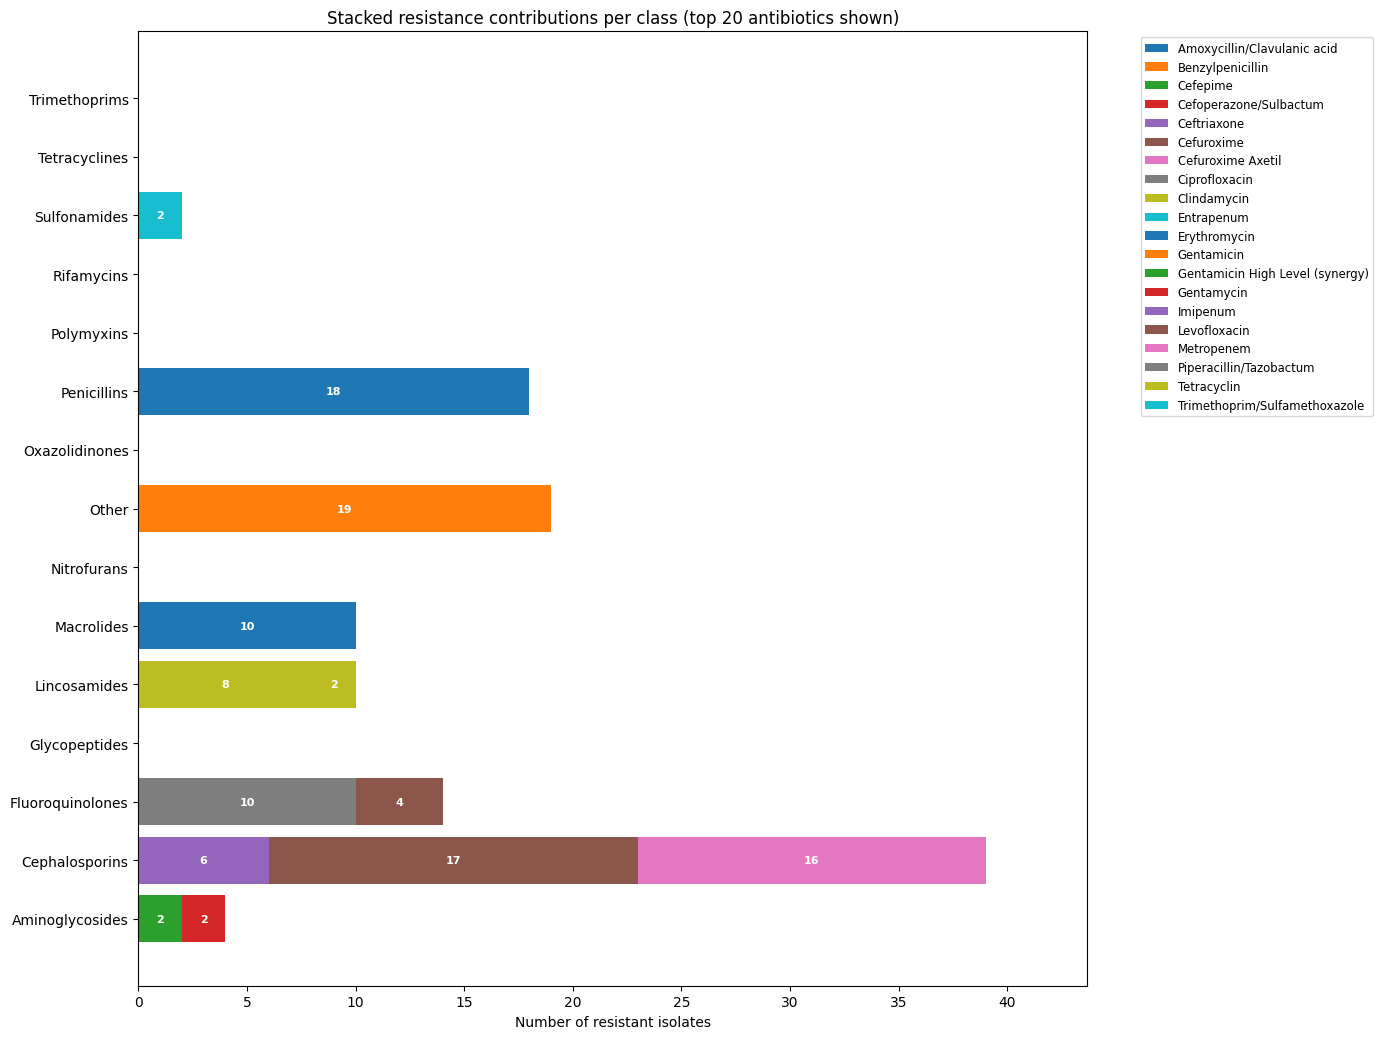

In [4]:
# === Stacked horizontal bars with robust labels and margin ===
import numpy as np
import matplotlib.pyplot as plt

# ensure pivot_reduced exists and index order is the same as earlier
# pivot_reduced: rows = classes, columns = antibiotics (top N), values = resistant counts

# Increase figure width & height so bars have space and top isn't touched
fig_height = max(8, 0.7 * len(pivot_reduced.index))
fig, ax = plt.subplots(figsize=(14, fig_height))

# compute total per class to set x-axis limits and threshold
class_totals = pivot_reduced.sum(axis=1)
xmax = class_totals.max() * 1.12  # add ~12% right margin
ax.set_xlim(0, xmax)

# set a dynamic minimum width threshold for placing labels INSIDE a segment
# (3% of the maximum class total works well; tune if necessary)
min_inside = class_totals.max() * 0.03

bottom = np.zeros(len(pivot_reduced))
antibiotics_order = list(pivot_reduced.columns)

# draw stacked bars and place labels
for ab in antibiotics_order:
    vals = pivot_reduced[ab].values
    rects = ax.barh(pivot_reduced.index, vals, left=bottom, label=ab)

    # Add numeric labels either inside segment (if wide enough) or just outside to right
    for rect, v in zip(rects, vals):
        if v <= 0:
            continue  # nothing to label

        seg_x = rect.get_x()
        seg_w = rect.get_width()
        seg_y = rect.get_y()
        seg_h = rect.get_height()
        label_text = str(int(v))

        # if segment wide enough, put label centered inside
        if seg_w >= min_inside:
            # choose contrasting color: white on dark-ish segment (heuristic)
            # if the bar color is light, black will be used by default text color
            # using white typically works well; if you want better contrast, compute luminance of color
            ax.text(seg_x + seg_w/2, seg_y + seg_h/2, label_text,
                    ha='center', va='center', fontsize=8, color='white', weight='bold', clip_on=False)
        else:
            # place label just outside the segment (small offset)
            ax.text(seg_x + seg_w + xmax*0.005, seg_y + seg_h/2, label_text,
                    ha='left', va='center', fontsize=8, color='black', clip_on=False)

    bottom = bottom + vals

# labels and title
ax.set_xlabel("Number of resistant isolates")
ax.set_title(f"Stacked resistance contributions per class (top {len(antibiotics_order)} antibiotics shown)")

# legend to the right
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()


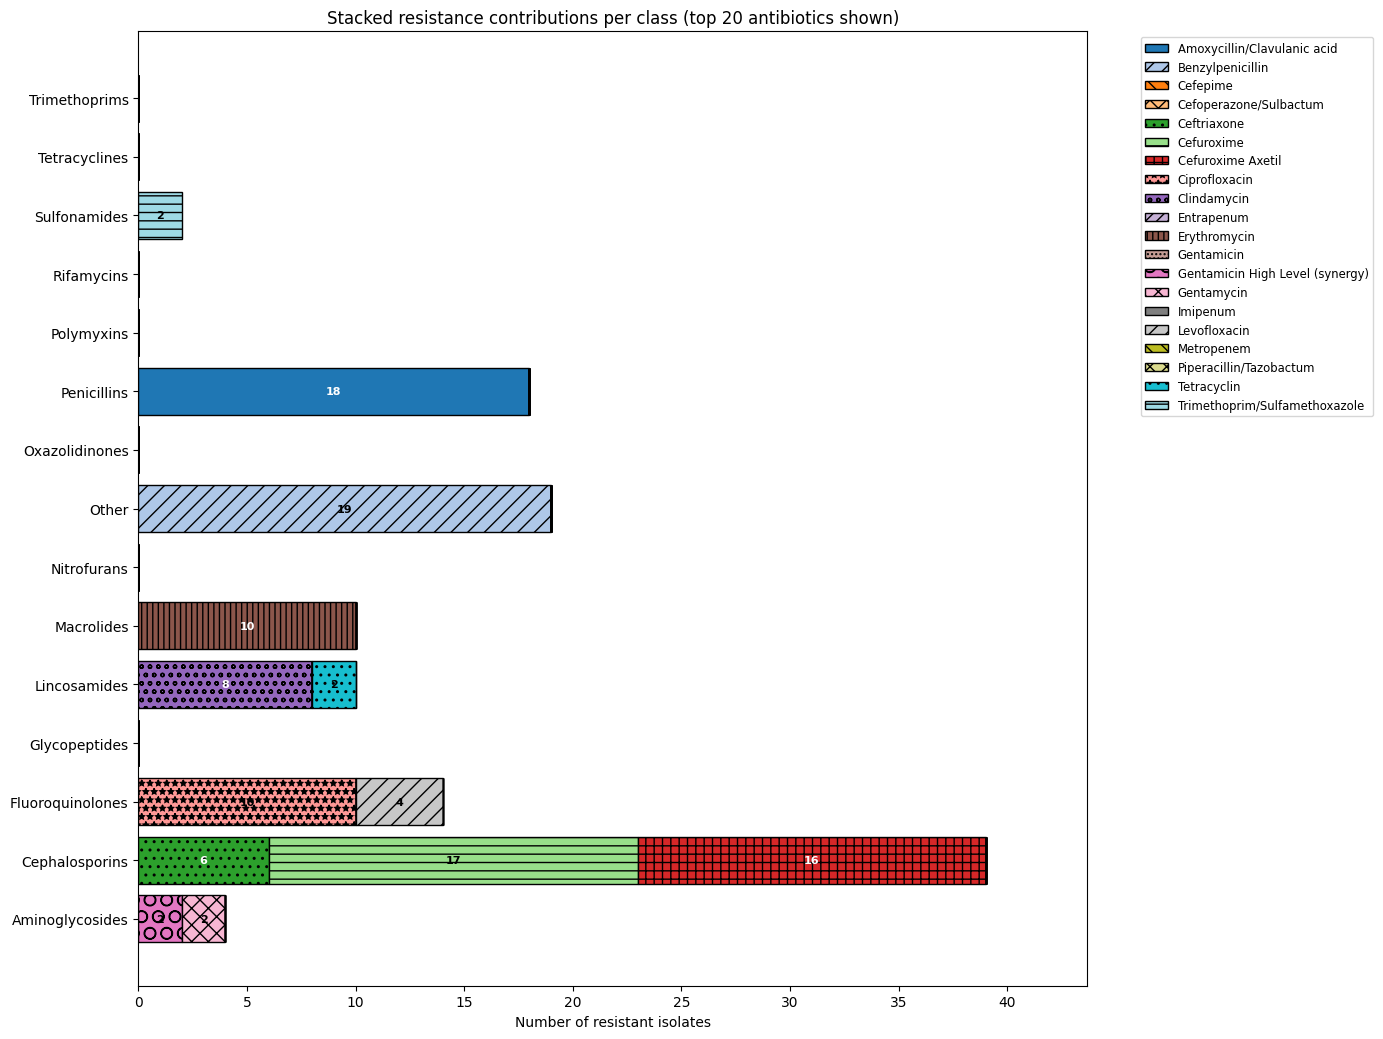

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgb

# ---------- Parameters ----------
fig_width = 14
fig_height = max(8, 0.7 * len(pivot_reduced.index))
min_inside_fraction = 0.03   # segment must be >= 3% of max class total to get inside label
right_margin_ratio = 0.12    # right margin of x-axis (12%)

# ---------- Prepare colours and hatches ----------
antibiotics_order = list(pivot_reduced.columns)
n_ab = len(antibiotics_order)

# Use a qualitative colormap (tab20) and sample it
cmap = plt.get_cmap("tab20")
colors = [cmap(i % 20) for i in range(n_ab)]  # repeat after 20 if necessary

# Hatch styles to help differentiate segments (cycle if needed)
hatch_styles = ["", "//", "\\\\", "xx", "..", "--", "++", "**", "oo", "///", "|||", "....", "O", "XX"]
hatches = [hatch_styles[i % len(hatch_styles)] for i in range(n_ab)]

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# compute totals and x-axis limits
class_totals = pivot_reduced.sum(axis=1)
xmax = class_totals.max() * (1 + right_margin_ratio)
ax.set_xlim(0, xmax)

# threshold for placing labels inside segments
min_inside = class_totals.max() * min_inside_fraction

bottom = np.zeros(len(pivot_reduced.index))
for i, ab in enumerate(antibiotics_order):
    vals = pivot_reduced[ab].values
    col = colors[i]
    hatch = hatches[i]
    rects = ax.barh(pivot_reduced.index, vals, left=bottom,
                    color=col, edgecolor='black', hatch=hatch, label=ab)

    # place labels inside or outside
    for rect, v in zip(rects, vals):
        if v <= 0:
            continue
        seg_x = rect.get_x()
        seg_w = rect.get_width()
        seg_y = rect.get_y()
        seg_h = rect.get_height()
        label_text = str(int(v))

        # compute luminance to decide label colour if placed inside
        r, g, b = to_rgb(col[:3]) if len(col) >= 3 else to_rgb(col)
        luminance = 0.299 * r + 0.587 * g + 0.114 * b
        inside_color = 'white' if luminance < 0.55 else 'black'

        if seg_w >= min_inside:
            ax.text(seg_x + seg_w / 2, seg_y + seg_h / 2,
                    label_text, ha='center', va='center',
                    fontsize=8, color=inside_color, weight='bold', clip_on=False)
        else:
            # small offset to the right
            ax.text(seg_x + seg_w + xmax * 0.005, seg_y + seg_h / 2,
                    label_text, ha='left', va='center',
                    fontsize=8, color='black', clip_on=False)

    bottom = bottom + vals

# ---------- Legend (colour + hatch) ----------
# Create patches in same order as antibiotics_order so legend matches
legend_handles = []
for i, ab in enumerate(antibiotics_order):
    patch = mpatches.Patch(facecolor=colors[i], edgecolor='black', hatch=hatches[i], label=ab)
    legend_handles.append(patch)

# Show legend to the right (may be large; you can reduce fontsize)
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Labels and title
ax.set_xlabel("Number of resistant isolates")
ax.set_title(f"Stacked resistance contributions per class (top {len(antibiotics_order)} antibiotics shown)")

plt.tight_layout()
plt.show()


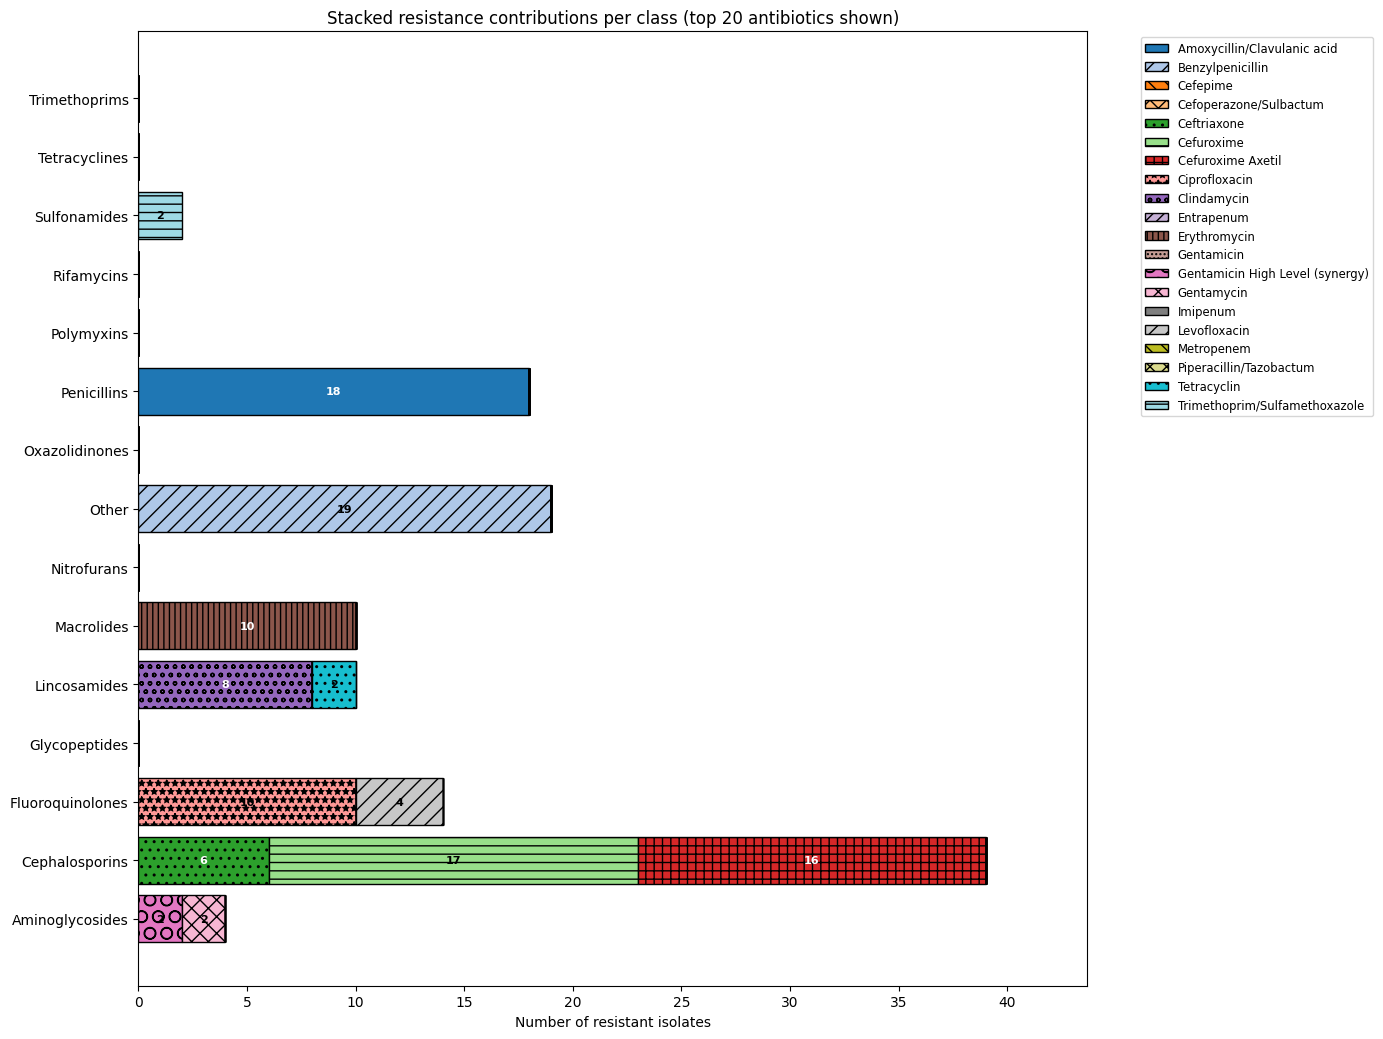

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgb

# ---------- Parameters ----------
fig_width = 14
fig_height = max(8, 0.7 * len(pivot_reduced.index))
min_inside_fraction = 0.03   # segment must be >= 3% of max class total to get inside label
right_margin_ratio = 0.12    # right margin of x-axis (12%)

# ---------- Prepare colours and hatches ----------
antibiotics_order = list(pivot_reduced.columns)
n_ab = len(antibiotics_order)

# Use a qualitative colormap (tab20) and sample it
cmap = plt.get_cmap("tab20")
colors = [cmap(i % 20) for i in range(n_ab)]  # repeat after 20 if necessary

# Hatch styles to help differentiate segments (cycle if needed)
hatch_styles = ["", "//", "\\\\", "xx", "..", "--", "++", "**", "oo", "///", "|||", "....", "O", "XX"]
hatches = [hatch_styles[i % len(hatch_styles)] for i in range(n_ab)]

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# compute totals and x-axis limits
class_totals = pivot_reduced.sum(axis=1)
xmax = class_totals.max() * (1 + right_margin_ratio)
ax.set_xlim(0, xmax)

# threshold for placing labels inside segments
min_inside = class_totals.max() * min_inside_fraction

bottom = np.zeros(len(pivot_reduced.index))
for i, ab in enumerate(antibiotics_order):
    vals = pivot_reduced[ab].values
    col = colors[i]
    hatch = hatches[i]
    rects = ax.barh(pivot_reduced.index, vals, left=bottom,
                    color=col, edgecolor='black', hatch=hatch, label=ab)

    # place labels inside or outside
    for rect, v in zip(rects, vals):
        if v <= 0:
            continue
        seg_x = rect.get_x()
        seg_w = rect.get_width()
        seg_y = rect.get_y()
        seg_h = rect.get_height()
        label_text = str(int(v))

        # compute luminance to decide label colour if placed inside
        r, g, b = to_rgb(col[:3]) if len(col) >= 3 else to_rgb(col)
        luminance = 0.299 * r + 0.587 * g + 0.114 * b
        inside_color = 'white' if luminance < 0.55 else 'black'

        if seg_w >= min_inside:
            ax.text(seg_x + seg_w / 2, seg_y + seg_h / 2,
                    label_text, ha='center', va='center',
                    fontsize=8, color=inside_color, weight='bold', clip_on=False)
        else:
            # small offset to the right
            ax.text(seg_x + seg_w + xmax * 0.005, seg_y + seg_h / 2,
                    label_text, ha='left', va='center',
                    fontsize=8, color='black', clip_on=False)

    bottom = bottom + vals

# ---------- Legend (colour + hatch) ----------
# Create patches in same order as antibiotics_order so legend matches
legend_handles = []
for i, ab in enumerate(antibiotics_order):
    patch = mpatches.Patch(facecolor=colors[i], edgecolor='black', hatch=hatches[i], label=ab)
    legend_handles.append(patch)

# Show legend to the right (may be large; you can reduce fontsize)
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Labels and title
ax.set_xlabel("Number of resistant isolates")
ax.set_title(f"Stacked resistance contributions per class (top {len(antibiotics_order)} antibiotics shown)")

plt.tight_layout()
plt.show()
